## Setting Up

In [1]:
# Turn on inline display of plots in the notebook. (We should work on a more
# portable solution such as saving th plots to files down the road.)
%matplotlib inline

In [2]:
import pyodbc

In [3]:
# Connect via Windows authentication:
# conn_specs = ('DRIVER={ODBC Driver 17 for SQL Server};'
#                                     + 'SERVER=scotty-test;'
#                                     + 'DATABASE=Interject_Reporting;'
#                                    + 'trusted_connection=yes;')
# conn_str = 'mssql+pyodbc:///?odbc_connect={}'.format(conn_specs)
# engine = sqla.create_engine(conn_str)

# Define a function that we can use to connect to a db on the fly:
def pyodbc_connect_scotty_test(db_name):
    try:
        connection = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};'
                                        + 'SERVER=scotty-test;'
                                        + 'DATABASE=' + db_name + ';'
                                       + 'trusted_connection=yes;')
        return connection
    except:
        return 1 # could not connect

In [4]:
import pandas as pd

In [17]:
# Connect to [Interject_Reporting]:
# intj_reporting_df = pd.read_sql('[DataCells].[Request]', engine)

reporting_conn = pyodbc_connect_scotty_test('Interject_Reporting')

In [18]:
# Create a cursor to run straight SQL queries:
# reporting_cursor = reporting_conn.cursor()

In [19]:
# Load [DataCells].[Request] and [DataCells].[Request_History] into DataFrames:
request = 'SELECT * FROM [DataCells].[Request]'  # Don't need * here...
request_history = 'SELECT * FROM [DataCells].[Request_History]'
request_df = pd.read_sql(request, reporting_conn) # So we don't need SQLalchemy...
request_history_df = pd.read_sql(request_history, reporting_conn) # So we don't need SQLalchemy...

## Visualizing DurationSeconds

[DataCells].[DurationSeconds] includes negative values for some reason... their absolute values are accurate, but just have a - in front of them...

In [7]:
request_df['DurationSeconds'].describe()

count    281.000000
mean       5.039146
std       60.829051
min      -10.000000
25%       -2.000000
50%       -1.000000
75%        0.000000
max      984.000000
Name: DurationSeconds, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x094EB9D0>]],
      dtype=object)

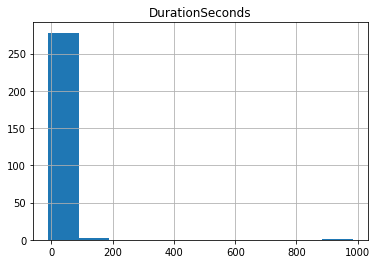

In [20]:
# Histogram of DurationSeconds:
request_df.hist(column='DurationSeconds')

## Visualizing request time durations manually (StartTimeStamp - EndTimeStamp)

Create a pd series that is ( StartTimeStamp - EndTimeStamp ). Doing this to resolve the negative DurationSeconds values reported above...

#### Setting Up

In [21]:
# Define a function that we can use with both [DataCells].[Request] and .[Request_History]
def get_request_time_durations(table_name):
    start_end_diff = 'SELECT datediff(second, [StartTimeStamp], [EndTimeStamp]) as StartEndDiffSeconds FROM [DataCells].[' + table_name + ']'
    return( pd.read_sql(start_end_diff, reporting_conn) )

    # # Do it with a cursor:
    # reporting_cursor.execute(start_end_diff_sql)
    # request_durations = pd.Series(reporting_cursor.fetchall())

In [12]:
request_durations = get_request_time_durations('Request')
request_history_durations = get_request_time_durations('Request_History')

#### Get some initial counts

How many data do we have for request durations in [Request] and [Request_History]?

In [13]:
request_durations.count()

StartEndDiffSeconds    281
dtype: int64

In [14]:
request_history_durations.count()

StartEndDiffSeconds    7417
dtype: int64


How many entries are NAN (not included in the previous counts)?

In [15]:
request_durations.isna().sum()

StartEndDiffSeconds    60
dtype: int64

In [16]:
request_history_durations.isna().sum()

StartEndDiffSeconds    67
dtype: int64

#### Describe Duration Data

In [17]:
request_durations.describe() 

,StartEndDiffSeconds
count,281.000000
mean,7.825623
std,60.532059
min,0.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,984.000000


In [18]:
request_history_durations.describe()

,StartEndDiffSeconds
count,7.417000e+03
mean,3.146081e+02
std,2.532012e+04
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,1.000000e+00
max,2.178484e+06


#### Plot query run time distributions using pd.unique() and pd.value_counts()

Find unique values and their frequencies, plot the distributions.

In [23]:
request_durations.shape

(341, 1)

In [24]:
request_durations.T.shape

(1, 341)

In [25]:
# 1D-ify them (should become series'):
request_durations_series = request_durations.squeeze()
request_history_durations_series = request_history_durations.squeeze()
print(request_durations_series.shape)
print(request_history_durations_series.shape)

type(request_durations_series) is pd.Series

# Didn't work...
# request_durations_arr = request_durations.values
# request_durations_arr.shape
# request_durations_series = pd.Series(request_durations_arr)

(341,)
(7484,)


True

In [28]:
# Save unique values:
request_unique_durs = request_durations_series.unique()
request_history_unique_durs = request_history_durations_series.unique()

print('[Request] unique time values: ')
print(request_unique_durs)
print('\n[Request_History] unique time values: ')
print(request_history_unique_durs)

[Request] unique time values: 
[  0.  12.  13.   9.   8.   1.   5.  11.  31.  27. 187. 180.  nan  24.
 984.  20.   2.   3.   4.   7.   6.]

[Request_History] unique time values: 
[0.000000e+00 1.000000e+00 4.000000e+00 3.000000e+00 4.600000e+01
 2.000000e+00 5.000000e+00          nan 8.000000e+00 6.000000e+00
 7.000000e+00 1.800000e+01 1.700000e+01 6.200000e+01 7.200000e+01
 1.100000e+01 1.980000e+02 2.000000e+01 1.600000e+01 1.900000e+01
 2.300000e+01 9.485300e+04 4.920000e+02 1.500000e+01 1.400000e+01
 1.200000e+01 9.000000e+00 4.000000e+01 2.200000e+01 2.100000e+01
 1.028400e+04 1.067300e+04 1.057100e+04 7.866000e+03 6.110000e+02
 6.090000e+02 6.390000e+02 6.520000e+02 2.400000e+01 3.130000e+02
 2.700000e+01 2.900000e+01 2.500000e+01 6.300000e+01 6.000000e+01
 1.720000e+02 6.100000e+01 6.600000e+01 6.400000e+01 3.660000e+02
 3.600000e+02 1.850000e+02 1.840000e+02 1.210000e+02 7.100000e+01
 7.600000e+01 7.800000e+01 7.700000e+01 7.500000e+01 1.450000e+02
 6.800000e+01 7.900000e+01 9.

In [30]:
# Get the frequencies for each unique duration:
request_dur_freq = request_durations_series.value_counts(dropna=False)
request_dur_freq

1.0      95
NaN      60
0.0      54
3.0      29
2.0      22
5.0      19
4.0      15
9.0      15
6.0       7
8.0       5
7.0       4
12.0      4
11.0      2
24.0      2
13.0      2
180.0     1
27.0      1
31.0      1
984.0     1
20.0      1
187.0     1
Name: StartEndDiffSeconds, dtype: int64

In [52]:
type(request_dur_freq) is pd.Series

True

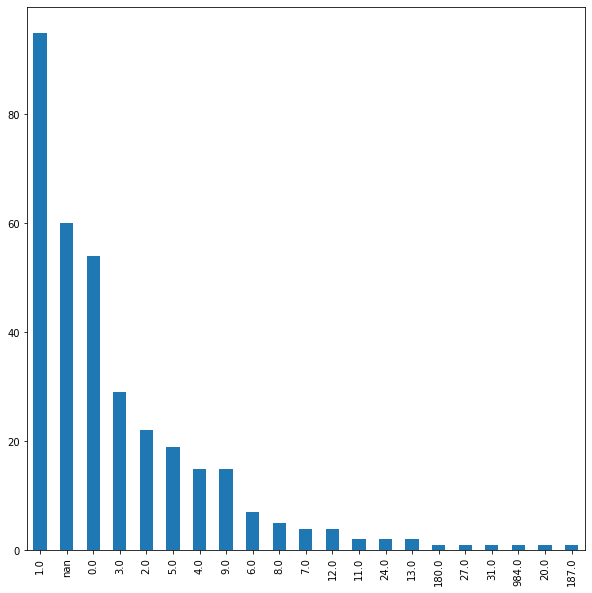

In [32]:
request_dur_freq.plot.bar(figsize=(10,10))

In [33]:
# request_dur_freq.hist(figsize=(10,30), bins=[1,2,3,4,5,6,7,8,9,10,15,20,30,40,50,60,70,80,90,100,150,200])

In [ ]:
request_history_dur_freq = request_history_durations_series.value_counts(dropna=False)
request_history_dur_freq

#### Try Astropy histrograms on large, non-normalized data set

In [36]:
import astropy.visualization as astv, astropy.stats as asts, scipy, numpy as np

In [ ]:
# On all data (request_history_durations_series):
request_history_durs_arr = pd.Series.to_numpy(request_history_durations_series)
print(request_history_durs_arr)
astv.hist(request_history_durs_arr, bins='blocks')

In [ ]:
request_history_freq_arr = pd.Series.to_numpy(request_history_dur_freq)
print(request_history_durs_arr)
astv.hist(request_history_freq_arr, bins='blocks')

In [39]:
# request_history_durations_arr = pd.Series.to_numpy(request_history_durations_series.T)
# print(request_history_durations_arr)
# request_history_time_freq_arr = pd.Series.to_numpy(request_history_time_freq)
# bins = asts.bayesian_blocks(request_history_durations_arr)
count, div = np.histogram(request_history_durations.dropna())
print(div)

[      0.   217848.4  435696.8  653545.2  871393.6 1089242.  1307090.4
 1524938.8 1742787.2 1960635.6 2178484. ]


In [ ]:
request_history_durations.dropna().hist(bins=div, figsize=(20,20))

In [ ]:
request_history_dur_freq.hist(bins="bins", figsize=(20,20))

In [ ]:
request_history_durations.plot.hist(figsize=(20,20), bins=[-1,100,200,20000000])

In [ ]:
request_history_dur_freq.plot.bar(figsize=(20,100))

## Vizualizing min/max request durations per week, by day

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
reporting_conn_2 = pyodbc_connect_scotty_test('Interject_Reporting')

In [7]:
# Select [EndTimeStamp] to mark the day, [Duration], from [Request] union with [Request_History] w/ SQL:
from_req = 'SELECT [EndTimeStamp], datediff(second, [StartTimeStamp], [EndTimeStamp]) AS Duration FROM [DataCells].[Request]'
union = ' UNION ALL'
from_req_hist = ' SELECT [EndTimeStamp], datediff(second, [StartTimeStamp], [EndTimeStamp]) AS Duration FROM [DataCells].[Request_History]'
request_all = from_req + union + from_req_hist
all_requests_df = pd.read_sql(request_all, reporting_conn_2, index_col='EndTimeStamp')

In [8]:
type(all_requests_df) is pd.DataFrame

True

In [9]:
all_requests_df.count() # excludes NANs

Duration    7698
dtype: int64

In [10]:
all_requests_df.isna().sum()

Duration    127
dtype: int64

In [74]:
all_requests_s = all_requests_df.squeeze()
type(all_requests_s) is pd.Series

False

In [166]:
all_requests_s.index

RangeIndex(start=0, stop=7825, step=1)

In [167]:
# Note: Resampler objects are returned by .resample() calls. Will not work until set index to EndTimeStamp!
# dur_by_day_resampler = all_requests_s.resample('D')
# max_dur_by_day_resampler = all_requests_s.resample('D').max()

In [ ]:
all_requests_s.count()

#### Create new DataFrame with max request duration for day, + more

In [ ]:
import datetime as dt

all_requests_df['Year'] = all_requests_df.index.year
all_requests_df['Month'] = all_requests_df.index.month
all_requests_df['Week'] = all_requests_df.index.week
all_requests_df['Day'] = all_requests_df.index.day
all_requests_df

# Create daily_max_request DF:
daily_max_request = all_requests_df.resample('D').max()
daily_max_request['Year'] = daily_max_request.index.year
daily_max_request['Month'] = daily_max_request.index.month
daily_max_request['Weekday'] = daily_max_request.index.weekday_name
daily_max_request = daily_max_request.dropna()
daily_max_request

# week_groups = daily_max_request.groupby([pd.Grouper(freq='W'), 'Duration'])
# weeks = pd.DataFrame()
# for dur, week in week_groups:
#     week_groups[week.dur] = week.values

# all_requests_df['day'] = all_requests_df.index.day
# all_requests_df['week'] = all_requests_df.index.week



In [ ]:
# Create a DF for each month:

def create_df_for_month(month_df, month_num): # Can python modify objects passed to it?
    for i in range(len(all_requests_df['Month'])): # 'Month' to be more readable/explicit
        if all_requests_df['Month'][i] = 1:
            month_df['Month'][i] = 

#### Use newly formed data to plot request durations by day

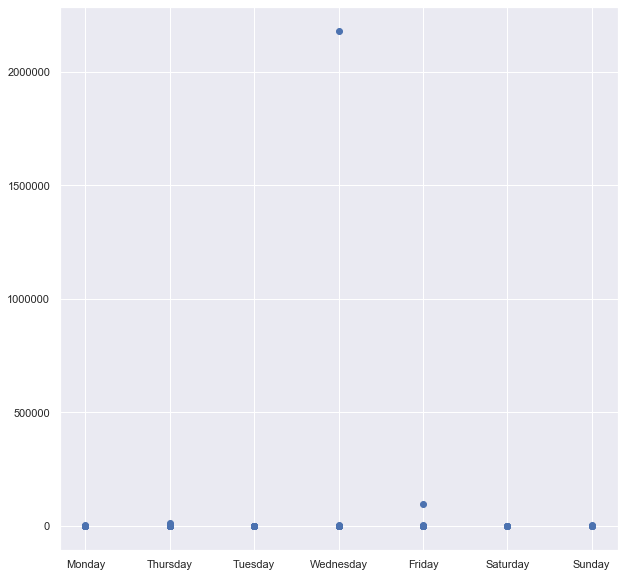

In [195]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x=daily_max_request.weekday, y=daily_max_request.Duration)
#ax.hist((daily_max_request.weekday))

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(10,10))

# Create the scatter plot for the first week:
ax1.scatter(x=daily_max_request.weekday, y=daily_max_request.Duration)

In [ ]:
# Use matplotlib object oriented approach to create a plot by day:

# Remove index...

request_days_arr = all_requests_df.day.values # Convert Series to nd array (transpose the matrix first)

#print(all_requests_arr[0])  # Debugging
# Convert Timestamp data (EndTimeStamp) to datetime:
#for i in range(len(all_requests_arr[0])):
#        all_requests_arr[0][i] = np.datetime64(all_requests_arr[0][i])
       # all_requests_arr[0][i] = np.datetime64(all_requests_arr[0][i])
#print(all_requests_arr[0])  # Debugging

fig, ax = plt.subplots()
ax.hist(all_requests_arr)

In [35]:
print(all_requests_df)
print(durations_by_day)

                EndTimeStamp  Duration
0    2015-05-30 21:23:56.533       0.0
1    2015-05-30 23:37:07.613      12.0
2    2015-05-30 23:38:38.177      13.0
3    2015-05-30 23:44:10.133       9.0
4    2015-05-30 23:51:13.860       8.0
...                      ...       ...
7820 2015-05-21 22:32:06.490       0.0
7821 2015-05-21 22:34:26.483       3.0
7822 2015-05-21 22:38:02.443       1.0
7823 2015-05-21 22:39:54.863       0.0
7824 2015-05-21 22:40:57.597       0.0

[7825 rows x 2 columns]
[[Timestamp('2015-05-30 21:23:56.533000') 0.0]
 [Timestamp('2015-05-30 23:37:07.613000') 12.0]
 [Timestamp('2015-05-30 23:38:38.177000') 13.0]
 ...
 [Timestamp('2015-05-21 22:38:02.443000') 1.0]
 [Timestamp('2015-05-21 22:39:54.863000') 0.0]
 [Timestamp('2015-05-21 22:40:57.597000') 0.0]]


In [ ]:
weeks = pd.DataFrame()

for day in durations_by_day.count():
    weeks[i] = 


for index, max_dur in durations_by_day:
    weeks[index] = max_dur.values
weeks.plot(subplots=True, legend=False)
plt.show()

## Seaborn

In [13]:
import seaborn as sns

#### Daily max request durations by weekday

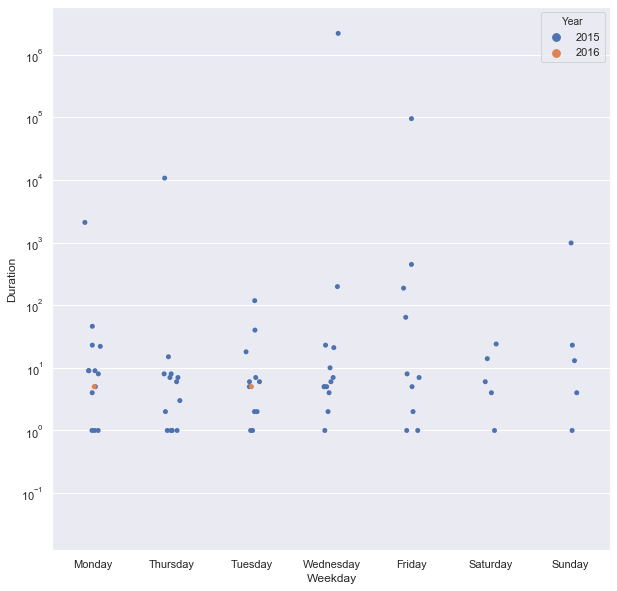

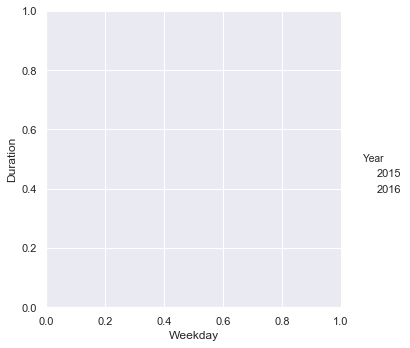

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set(yscale='log')
sns.catplot(x='Weekday', y='Duration', hue='Year', data=daily_max_request, ax=ax)